In [1]:
from compare_simulators import CalculatorComparator
from population_simulator import CerfaPopulationSimulator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Creating the comparator and loading existing results

comp = CalculatorComparator()
comp.load_results_from_json('1aj-1bj-f-2000')

salaire1 = comp.get_variable_from_testcases('1AJ')
salaire2 = comp.get_variable_from_testcases('1BJ')
salaire = list([(salaire1[i] + salaire2[i]) for i in range(0, len(salaire1))])

revdisp = comp.get_variable_from_openfisca('revdisp')
impot_openfisca = comp.get_variable_from_openfisca('irpp') 
impot_m = comp.get_variable_from_m('IRN')
impot_online = comp.get_variable_from_online('IINET')


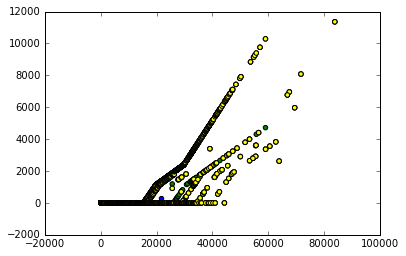

In [3]:
# Plotting results from calculators for the impot sur le revenu

# x = salary
# y_yellow = impot_online (official site)
# y_green = impot_m
# y_blue = impot_openfisca

plt.scatter(
    salaire + salaire + salaire,
    impot_openfisca + impot_m + impot_online,
    c=['blue'] * len(impot_openfisca) + ['green'] * len(impot_m) + ['yellow'] * len(impot_online))

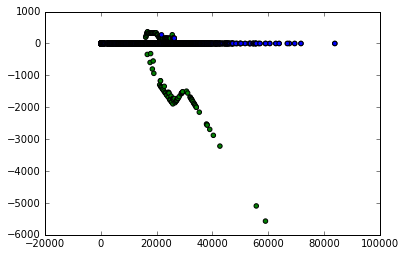

In [4]:
# Computing difference between calculators
diff_openfisca = [a_i - b_i for a_i, b_i in zip(impot_openfisca, impot_online)]
diff_m = [a_i - b_i for a_i, b_i in zip(impot_m, impot_online)]

# TOOL 1 to find discrepencies: differences

# Plotting difference between:
# 1) openfisca and online
# 2) m and online

# x = salary (1AJ)
# y_yellow = difference between openfisca and online calculator
# y_blue = difference between m and online calculator

####################################
# Filtering dimensions of interest #
####################################
# for i in range(0, len(salaire1)):
#     #Removing veufs and children
#      if ('V' in comp.testcases[i]):
# #             or ('F' in comp.testcases[i] and comp.testcases[i]['F'] > 0)):
# #     if ('F' in comp.testcases[i] and comp.testcases[i]['F'] != 2):    
#         diff_m[i] = -1000
# #         diff_openfisca[i] = -1000

plt.scatter(
    salaire + salaire,
    diff_m + diff_openfisca,
    c=['green'] * len(diff_m) + ['blue'] * len(diff_openfisca))

In [5]:
# TOOL 2 to find discrepencies: commun ground

# Computing Probable outliner:
# if two calculators are equal and one is different, the different might be the one buggy

def commun(a, b, c):
    diffa = min(abs(a-b), abs(a-c))
    diffb = min(abs(a-b), abs(b-c))
    diffc = min(abs(c-b), abs(a-c))

    if diffa <= diffb and diffa <= diffc:
        return a
    if diffb <= diffa and diffb <= diffc:
        return b
    if diffc <= diffa and diffc <= diffb:
        return c
    # We do not handle yet the hypothetic case of a circular reference
    print 'Circular condition, please define behavior here' 
    assert(False)

probable_true_tax = []
for i in range(0, len(impot_m)):
    probable_true_tax.append(commun(impot_m[i], impot_online[i], impot_openfisca[i]))

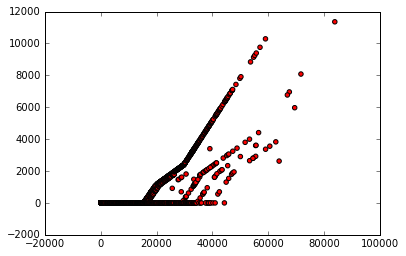

In [6]:
# x = salary
# y = probable_true_tax

plt.scatter(
    salaire,
    probable_true_tax,
    c= ['red'] * len(probable_true_tax))

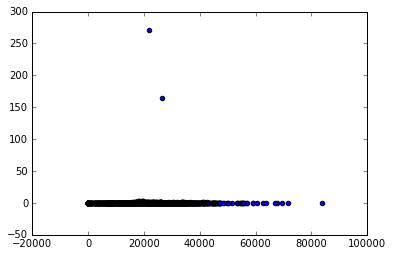

In [7]:
# Errors of openfisca
error_openfisca = [abs(a_i - b_i) for a_i, b_i in zip(impot_openfisca, probable_true_tax)]

plt.scatter(
    salaire,
    error_openfisca)


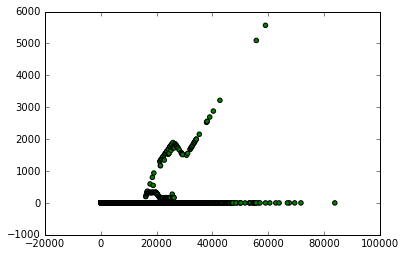

In [8]:
# Errors of m
error_m = [abs(a_i - b_i) for a_i, b_i in zip(impot_m, probable_true_tax)]

plt.scatter(
    salaire,
    error_m,
    c=['green'] * len(impot_m))

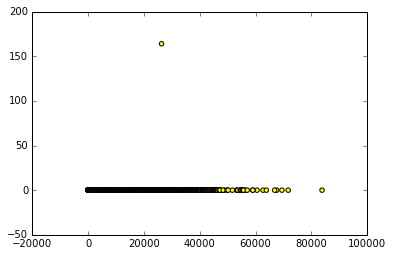

In [9]:
# Errors of online
error_online = [abs(a_i - b_i) for a_i, b_i in zip(impot_online, probable_true_tax)]

plt.scatter(
    salaire,
    error_online,
    c=['yellow'] * len(impot_online))

In [10]:
# TOOL 3 to find discrepencies: showing worst testcases

def show_highest_discrepencies(my_list):
    index_errors = sorted(range(len(my_list)), key=lambda k: my_list[k], reverse=True)
    average_age = 0

    from input_variable_converter import CerfaOpenFiscaConverter
    input_converter = CerfaOpenFiscaConverter()
    worst_testcases = []
    for i in range(0, len(salaire)):
        idx = index_errors[i]
        print 'Testcase: ' + repr(comp.testcases[idx])
        print 'Impot m: ' + repr(int(impot_m[idx]))
        print 'Impot openfisca: ' + repr(int(impot_openfisca[idx]))
        print 'Impot online: ' + repr(int(impot_online[idx]))
        worst_testcases.append(comp.testcases[index_errors[i]])
    return worst_testcases

In [11]:
worst_testcases = show_highest_discrepencies(error_openfisca)

Testcase: {u'V': 1, u'F': 1, u'year': 2014, u'0DA': 1969, u'1AJ': 21732}
Impot m: 0
Impot openfisca: 271
Impot online: 0
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1929, u'1AJ': 26308}
Impot m: 69
Impot openfisca: 1958
Impot online: 1794
Testcase: {u'C': 1, u'1AJ': 19605, u'0DA': 1927, u'year': 2014}
Impot m: 1093
Impot openfisca: 765
Impot online: 763
Testcase: {u'C': 1, u'1AJ': 19485, u'0DA': 1933, u'year': 2014}
Impot m: 1061
Impot openfisca: 735
Impot online: 733
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1942, u'1AJ': 17835}
Impot m: 0
Impot openfisca: 319
Impot online: 317
Testcase: {u'C': 1, u'1AJ': 19787, u'0DA': 1944, u'year': 2014}
Impot m: 1137
Impot openfisca: 811
Impot online: 809
Testcase: {u'C': 1, u'1AJ': 18358, u'0DA': 1928, u'year': 2014}
Impot m: 777
Impot openfisca: 451
Impot online: 449
Testcase: {u'1AJ': 19469, u'D': 1, u'0DA': 1945, u'year': 2014}
Impot m: 1057
Impot openfisca: 731
Impot online: 729
Testcase: {u'C': 1, u'1AJ': 18404, u'0DA': 1930, u'year': 2014}


In [12]:
# TOOL 3.2 to find discrepencies: analyzing the worst testcases
from compare_simulators import CalculatorComparator

comparator = CalculatorComparator()

# comparator.simulate_m([worst_testcases[0]], {})
# comparator.simulate_of([worst_testcases[0]])
# comparator.simulate_online([worst_testcases[0]],{})

In [13]:
show_highest_discrepencies(error_m)

Testcase: {u'V': 1, u'year': 2014, u'0DA': 1929, u'1AJ': 58998}
Impot m: 4721
Impot openfisca: 10290
Impot online: 10291
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1932, u'1AJ': 55698}
Impot m: 4305
Impot openfisca: 9399
Impot online: 9400
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1969, u'1AJ': 42663}
Impot m: 2662
Impot openfisca: 5880
Impot online: 5880
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1935, u'1AJ': 40317}
Impot m: 2367
Impot openfisca: 5246
Impot online: 5247
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1983, u'1AJ': 39021}
Impot m: 2203
Impot openfisca: 4896
Impot online: 4897
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1947, u'1AJ': 38096}
Impot m: 2087
Impot openfisca: 4646
Impot online: 4647
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1953, u'1AJ': 38030}
Impot m: 2079
Impot openfisca: 4629
Impot online: 4629
Testcase: {u'V': 1, u'year': 2014, u'0DA': 1948, u'1AJ': 37855}
Impot m: 2056
Impot openfisca: 4581
Impot online: 4582
Testcase: {u'V': 1, u'year': 2014, u'0DA': 195

[{u'0DA': 1929, u'1AJ': 58998, u'V': 1, u'year': 2014},
 {u'0DA': 1932, u'1AJ': 55698, u'V': 1, u'year': 2014},
 {u'0DA': 1969, u'1AJ': 42663, u'V': 1, u'year': 2014},
 {u'0DA': 1935, u'1AJ': 40317, u'V': 1, u'year': 2014},
 {u'0DA': 1983, u'1AJ': 39021, u'V': 1, u'year': 2014},
 {u'0DA': 1947, u'1AJ': 38096, u'V': 1, u'year': 2014},
 {u'0DA': 1953, u'1AJ': 38030, u'V': 1, u'year': 2014},
 {u'0DA': 1948, u'1AJ': 37855, u'V': 1, u'year': 2014},
 {u'0DA': 1953, u'1AJ': 35276, u'V': 1, u'year': 2014},
 {u'0DA': 1932, u'1AJ': 34212, u'V': 1, u'year': 2014},
 {u'0DA': 1978, u'1AJ': 34201, u'V': 1, u'year': 2014},
 {u'0DA': 1932, u'1AJ': 33884, u'V': 1, u'year': 2014},
 {u'0DA': 1947, u'1AJ': 33598, u'V': 1, u'year': 2014},
 {u'0DA': 1974, u'1AJ': 25799, u'V': 1, u'year': 2014},
 {u'0DA': 1979, u'1AJ': 33358, u'V': 1, u'year': 2014},
 {u'0DA': 1990, u'1AJ': 33347, u'V': 1, u'year': 2014},
 {u'0DA': 1963, u'1AJ': 26576, u'V': 1, u'year': 2014},
 {u'0DA': 1968, u'1AJ': 25370, u'V': 1, u'year':

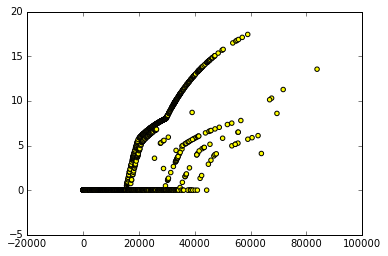

In [14]:
# Marginal tax rate

probable_true_marginal_rate = []
for i in range(0, len(salaire)):
    probable_true_marginal_rate.append(100 * probable_true_tax[i] / (salaire[i]+0.01))
plt.scatter(
    salaire,
    probable_true_marginal_rate,
    c=['yellow'] * len(impot_online))

In [15]:
# TOOL 4 to find discrepencies: weighting input variables by error

# For instance, we could find a bug that people born in 1936 with a salary of 19k have a discrepency in M

combined_total = {}
combined_total_ref = {}
combined_diff = {}
for var in comp.testcases[0]:
    combined_total[var] = 0
    combined_total_ref[var] = 0
combined_weights = 0 

for i in range(0, len(salaire)):
    for var in comp.testcases[i]:
        combined_total[var] = combined_total.get(var, 0) + comp.testcases[i].get(var, 0) * error_openfisca[i]
        combined_total_ref[var] = combined_total_ref.get(var, 0) + comp.testcases[i][var]
    combined_weights += error_openfisca[i]
for var in combined_total:
    combined_total[var] = combined_total[var] / combined_weights
    combined_total_ref[var] = combined_total_ref[var] / len(salaire)
    combined_diff[var] = combined_total[var] - combined_total_ref[var]

print 'Reference average: ' + repr(combined_total_ref)
print 'Weighted by bug average: ' + repr(combined_total)
print 'Difference: ' + repr(combined_diff)


Reference average: {u'C': 0, u'D': 0, u'F': 0, u'V': 0, u'M': 0, u'O': 0, u'year': 2014, u'1BJ': 1053, u'0DB': 662, u'0DA': 1960, u'1AJ': 12602}
Weighted by bug average: {u'C': 0.20359457010326854, u'D': 0.06538539526454148, u'F': 0.4338166288344384, u'V': 0.6846897009609086, u'M': 0.0415385305543842, u'O': 0.0047918031168970995, u'year': 2014.0, u'1BJ': 400.3854568129413, u'0DB': 90.73543967628771, u'0DA': 1954.0820438375338, u'1AJ': 24448.186745022744}
Difference: {u'C': 0.20359457010326854, u'D': 0.06538539526454148, u'F': 0.4338166288344384, u'year': 0.0, u'M': 0.0415385305543842, u'O': 0.0047918031168970995, u'V': 0.6846897009609086, u'1BJ': -652.6145431870586, u'0DB': -571.2645603237123, u'0DA': -5.917956162466226, u'1AJ': 11846.186745022744}


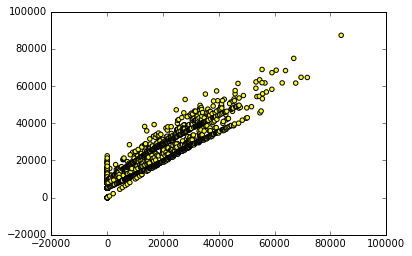

In [16]:
# Disposable income
plt.scatter(
    salaire,
    revdisp,
    c=['yellow'] * len(impot_online))

In [17]:
for i in range(0, len(salaire)):
    if revdisp[i] > salaire[i] + 18000 and ('C' in comp.testcases[i]) and ('F' in comp.testcases[i]) and comp.testcases[i]['F'] < 4:
        print revdisp[i]
        print comp.testcases[i]


18610.1621094
{u'C': 1, u'year': 2014, u'F': 3, u'0DA': 1931, u'1AJ': 0}


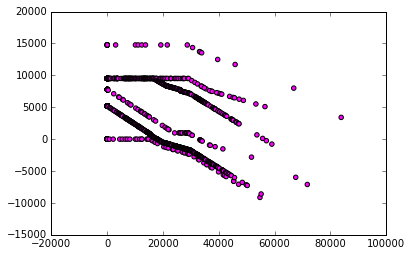

In [18]:
# Government help:
balance_x = []
balance_y = []
for i in range(0, len(salaire)):
    if ('F' not in comp.testcases[i]):
        balance_x.append(salaire[i])
        balance_y.append(revdisp[i] - salaire[i])

# Disposable income
plt.scatter(
    balance_x,
    balance_y,
    c=['magenta'] * len(impot_online))

In [19]:
# comparator.simulate_m([{u'C': 1, u'1AJ': 0, u'0DA': 1992, u'year': 2014}], {})
test = comparator.simulate_of([{u'F': 2, u'M': 1, u'year': 2014, u'1BJ': 0, u'0DB': 1950, u'0DA': 1981, u'1AJ': 0}])
# comparator.simulate_online([{u'C': 1, u'1AJ': 0, u'0DA': 1992, u'year': 2014}],{})


Simulating OF
INFO: converting birthdate from "1981" to "1981-1-1"
INFO: converting birthdate from "1950" to "1950-1-1"
{'enfants': [{'date_naissance': '2010-1-1'}, {'date_naissance': '2010-1-1'}], 'parent2': {u'salaire_imposable': 0, 'statut_marital': 1, 'date_naissance': '1950-1-1'}, 'parent1': {u'salaire_imposable': 0, 'statut_marital': 1, 'date_naissance': '1981-1-1'}, 'period': 2014}
Irpp openfisca = -0.0
Revdisp openfisca = 11140.2021484375
Openfisca took 12.0484478474 seconds
